In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

In [3]:
''' crystal variables  '''
crystal_type='220'
ang_as = np.deg2rad(5)           # asymmetric angle

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638            # reflecting plane d-spacing [A]
    psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
    psi0i = 3.58887560736e-06       # imaginary part of ""
    psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
    psi_hi = 2.50565837652e-06      # imaginary part of ""
    psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
    psi_hbi = 2.50565837652e-06     # imaginary part of ""
    
if crystal_type == '220':
    ''' Silicon 220 crystal '''
    d_sp = 1.9201374688016222        # reflecting plane d-spacing [A]
    psi0r = -9.7640050694412e-06     # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.4938680132506875e-07   # imaginary part of ""
    psi_hr = -5.932463856370471e-06  # real part of Hth Fourier component
    psi_hi = 1.44406950529943e-07    # imaginary part of ""
    psi_hbr = -5.932463856370471e-06 # real part of -Hth Fourier coumponent
    psi_hbi = 1.44406950529943e-07   # imaginary part of ""
    
tc = 150e-6                       # crystal thickness
uc = 1                            # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = 0                 # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' incident beam variables '''
ekev = 9.5                  # photon energy [kev]
pulse_duration = 0.2e-15    # pulse duration (rms) [s]
z1 = 400                  # distance to first OE [m]
sigX = 30e-6/(2*np.sqrt(2*np.log(2)))  # w0 (rms) [m]
npoints = 100               # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.1e-15                # time sampling resolution

hbar = 6.582119569e-16

# input dimensions
npointsx = npoints                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

# Calculate sampling paremeters

In [4]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = 2000e-6    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
pulseRange = trange/pulse_duration

if pulseRange < 400:
    pulseRange = 400
    trange = pulse_duration * pulseRange

if trange > 800e-15:
    trange = 800e-15
    pulseRange = trange/pulse_duration

if trange < 300e-15:
    trange = 300e-15
    pulseRange = trange/pulse_duration

dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
    
''' diffraction limit and focal spot Rayleigh range '''
#thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
#dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
#zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
#print('diffraction limit {}um, Rayleigh range {}mm, Fresnel distance {}um'.format(
#    round(dlim*1e6,2), round(zR*1e3,2), round((3e8*0.1e-15)**2/wl0*1e6,2)))


beam parameters:
    9.5keV, 0.2fs, 12.74um w0, 3.26urad divergence
sampling parameters:
    0.1fs dt, 5.17meV deV, 8000 nz, 4000.0 pulseRange
other parameters:
    Bragg angle 19.87deg, stretched pulse length 800.0fs


In [5]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}fs_beam/'.format(
    round(pulse_duration*1e15,1))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

# sub-sub-folder for propagated beam
dirname_split_delay = dirname_duration+'split-delay/'
if not os.path.exists(dirname_split_delay):
    mkdir_p(dirname_split_delay)
    
dirname_prop = dirname_duration+'prism/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

In [6]:
fname_incident = dirname_input + 'incident_wavefront.h5'

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))


generating incident wavefront
saving incident wavefront
finished in 40.47s


done


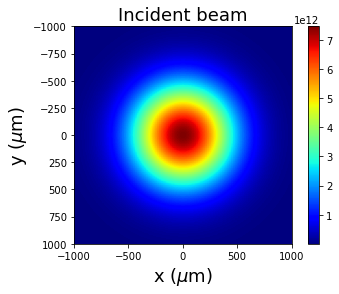

In [7]:
''' transverse intensity profile '''
# spatial profile
fig = plt.figure()
ax1 = fig.add_subplot(111)

if min([npointsx, npointsy])>=4:
    plot_spatial_from_wf(mwf,'incident')
    ax1.set_aspect('equal')
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout_from_wf(mwf, 'C1',label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')
    
print('done')


R-space
R-space


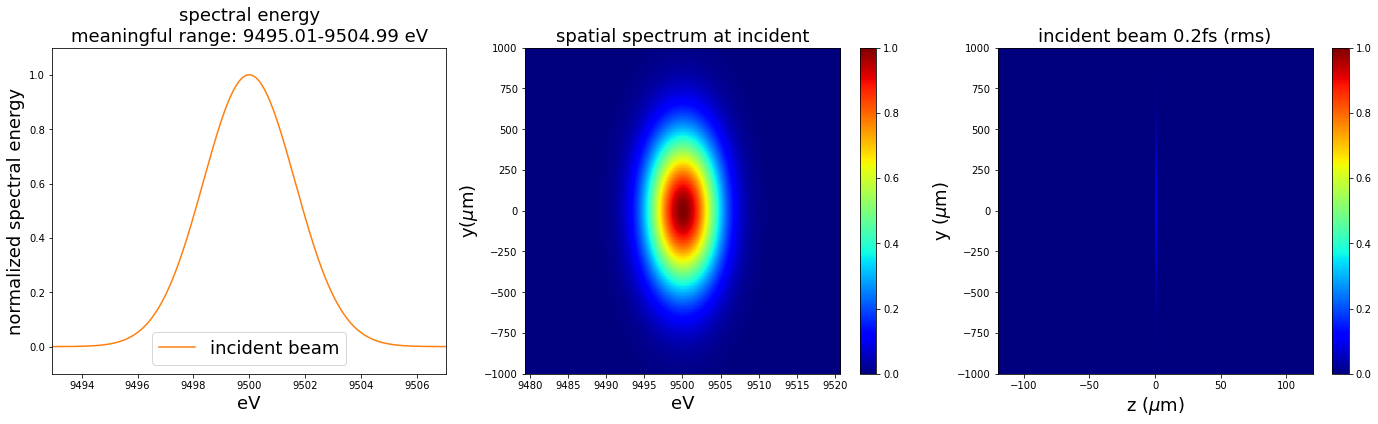

In [8]:
''' plot incident beam structure '''
plt.figure(figsize=(24,6))
# spectra
plt.subplot(1,3,1)
aw, evI, intIs = get_spectra(mwf)
eRange = evI.max()-evI.min()
eMin = evI[aw.min()]-eRange/20
eMax = evI.max()-(eMin-evI.min())

plot_spectra(aw, evI, intIs,'C1', label='incident beam')
plt.xlim([eMin, eMax])
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin

# spatial spectra
fov_t = trange*3e8*1e6    # um
fov_y = range_xy*1e6   # um

plt.subplot(1,3,2)
plot_tilt_freq_from_wf(mwf,label='incident',ori='V',if_log=0)
plt.xlim([eStart, eFin]); plt.ylim([-fov_y/2,fov_y/2])

# spatial temporal profile
plt.subplot(1,3,3)
plot_tilt_from_wf(mwf,label='incident',ori='V',if_log=0)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.title('incident beam {}fs (rms)'.format(round(pulse_duration*1e15,2)), fontsize=18)

plt.savefig(dirname_input+'incident_beam_profile.png', transparent=True)


### crystal positions

CC0 -> CC1 ->  {VCC0 -> VCC1 -> VCC2 -> VCC3}  -> CC2 -> CC3

z2_CC = z2; z3_CC = 2*z_off + z3; z4_CC = z4; z5_CC = z5 - z_off


# Define beamline optics

In [9]:
from Optics import *
''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = -ang_as           # """""""""""""""""""""" second crystal
ang_as2 = 0                 # """""""""""""""""""""" third crystal
ang_as3 = -ang_as            # """""""""""""""""""""" 4th crystal

OE_Crystal0 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
OE_Crystal1 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
OE_Crystal2 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
OE_Crystal3 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

OE_Crystal0_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
OE_Crystal1_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
OE_Crystal2_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
OE_Crystal3_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)

''' crystal orientation '''
set_crystal_orient(OE_Crystal0, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal1, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal3, ekev*1e3, ang_dif_pl, flip=0)

set_crystal_orient(OE_Crystal0_CC, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal1_CC, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal2_CC, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal3_CC, ekev*1e3, ang_dif_pl, flip=1)


### Define beamline

In [10]:
''' propagation distance '''
z_off = 0.12	# distance offset between VCC crystal 0 and CC crystal 0
z2 = 0.02		# distance between crystal 0 and 1
z3 = 0.2		# distance between crystal 1 and 2
z4 = 0.02		# distance between crystal 2 and 3
z5 = z_off+0.01		# distance between crystal 3 and detector

z2_CC = z2		# distance between crystal 0 and 1
z3_CC = 2*z_off+z3		# distance between crystal 1 and 2
z4_CC = z4		# distance between crystal 2 and 3
z5_CC = z5 - z_off		# distance between crystal 3 and detector

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppDriftIn =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal0 =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0 =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1 =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1 =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppCrystal2 =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC2 =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal3 =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC3 =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppCrystal0_CC =   [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0_CC =    [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1_CC =   [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1_CC =    [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppCrystal2_CC =   [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC2_CC =    [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal3_CC =   [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC3_CC =    [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
# branch 1 (VCC)
DriftIn = SRWLOptD(z_off)   # CC crystal 0 to VCC crystal 0 offset
DriftC0 = SRWLOptD(z2)    # crystal 0 to 1
DriftC1 = SRWLOptD(z3)    # crystal 1 to 2
DriftC2 = SRWLOptD(z4)    # crystal 2 to 3
DriftC3 = SRWLOptD(z5)    # crystal 3 to detector

name0 = 'incident'
name1 = 'vcc'
BL0 = SRWLOptC([DriftIn, OE_Crystal0, DriftC0, OE_Crystal1, DriftC1, OE_Crystal2, DriftC2, OE_Crystal3, DriftC3],
               [ppDriftIn, ppCrystal0, ppDriftC0, ppCrystal1, ppDriftC1, ppCrystal2, ppDriftC2, ppCrystal3, ppDriftC3])

# branch 2 (CC)
DriftC0_CC = SRWLOptD(z2_CC)    # crystal 0 to 1
DriftC1_CC = SRWLOptD(z3_CC)    # crystal 1 to 2
DriftC2_CC = SRWLOptD(z4_CC)    # crystal 2 to 3
DriftC3_CC = SRWLOptD(z5_CC)    # crystal 3 to detector

name0_CC = 'incident_CC'
name1_CC = 'cc'
BL0_CC = SRWLOptC([OE_Crystal0_CC, DriftC0_CC, OE_Crystal1_CC, DriftC1_CC, OE_Crystal2_CC, DriftC2_CC, OE_Crystal3_CC, DriftC3_CC],
                  [ppCrystal0_CC, ppDriftC0_CC, ppCrystal1_CC, ppDriftC1_CC, ppCrystal2_CC, ppDriftC2_CC, ppCrystal3_CC, ppDriftC3_CC])

print('done')

done


In [11]:
''' propagation '''
# branch 1 (VCC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through vcc, t = {}s'.format(round(time.time()-startTime,2)))
fname_vcc1 = dirname_split_delay + '1_wavefront_after_vcc.h5'
mwf_vcc1 = propagate_wavefront(fname_incident, BL0, fname_vcc1)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# branch 2 (CC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through cc, t = {}s'.format(round(time.time()-startTime,2)))
fname_cc1 = dirname_split_delay + '1_wavefront_after_cc.h5'
mwf_cc1 = propagate_wavefront(fname_incident, BL0_CC, fname_cc1)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))




*** through vcc, t = 0.0s
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.12
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 9500.0
	dSp = 1.9201374688016222
	nvx = 0
	nvy = 0.9404764060876707
	nvz = -0.3398589848634559
	psi0i = 1.4938680132506875e-07
	psi0r = -9.7640050694412e-06
	psiHbi = 1.44406950529943e-07
	psiHbr = -5.932463856370471e-06
	psiHi = 1.44406950529943e-07
	psiHr = -5.932463856370471e-06
	tc = 0.00015
	tvx = 0
	tvy = 0.3398589848634559
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.02
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 3.141592653589793
	aux_energy = 9500.0
	dSp = 1.9201374688016222
	nvx = -1.1110953428071594e-16
	nvy = -0.9

In [12]:
# check dimensions
print('incident',np.asarray(mwf.get_limits())*1e6)
print('vcc1',np.asarray(mwf_vcc1.get_limits())*1e6)
print('cc1',np.asarray(mwf_cc1.get_limits())*1e6)

R-space
incident [-1000.  1000.  1000. -1000.]
R-space
vcc1 [-1010.5442887    990.33340293   368.72904173  -376.25412421]
R-space
cc1 [-1010.5359653    990.32524599   990.33169516 -1010.54254608]


### propagate branch 2 (CC)

# Plots

R-space
R-space
R-space


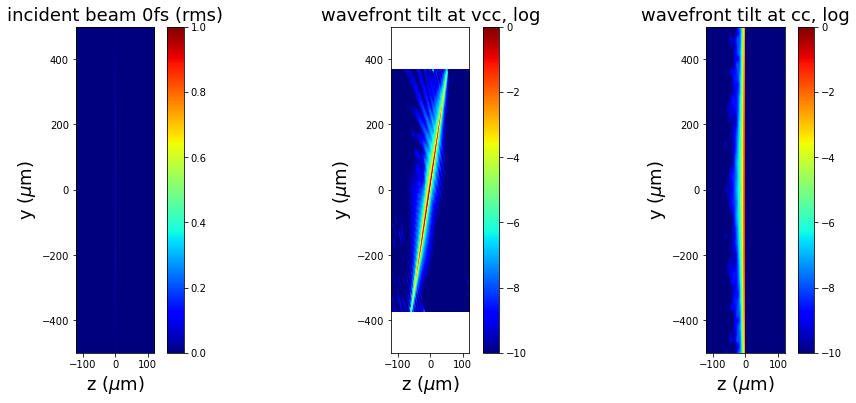

In [15]:
''' structure everywhere '''
ori = 'V'
if_log = 1
fov_y = 1000    # um
fov_t = trange*3e8*1e6    # um

fig = plt.figure(figsize=(16,6))
# spatial temporal profile
ax1 = fig.add_subplot(131)
plot_tilt_from_wf(mwf,label=name0,if_log=0)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.title('incident beam {}fs (rms)'.format(round(pulse_duration*1e15)), fontsize=18)
ax1.set_aspect('equal')

ax2 = fig.add_subplot(132)
plot_tilt_from_wf(mwf_vcc1,label=name1,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
ax2.set_aspect('equal')

ax3 = fig.add_subplot(133)
plot_tilt_from_wf(mwf_cc1,label=name1_CC,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
ax3.set_aspect('equal')
plt.savefig(dirname_split_delay+'wavefront_tilt_everywhere.png',transparent=True)


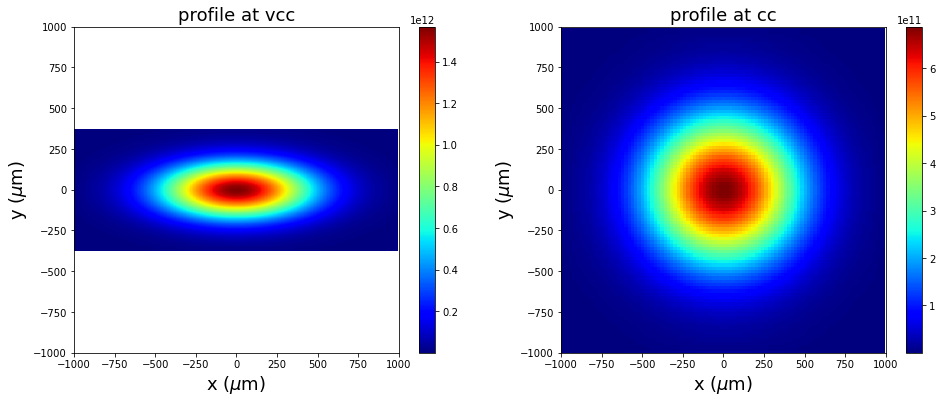

In [16]:
''' spatial profile '''
if_log = 0
fov = 1000
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_spatial_from_wf(mwf_vcc1, label=name1, if_log=if_log)
plt.xlim([-fov,fov]); plt.ylim([-fov,fov])

plt.subplot(1,2,2)
plot_spatial_from_wf(mwf_cc1, label=name1_CC, if_log=if_log)
plt.xlim([-fov,fov]); plt.ylim([-fov,fov])

plt.savefig(dirname_split_delay+'profile_at_split-delay_output.png',transparent=True)

### Compress save

In [17]:
fname_incident = dirname_input+'incident_compressed.h5'

''' incident '''
for filename in os.listdir(dirname_input):
    if filename.endswith('.h5'):
        if not filename.endswith('compressed.h5'):
            os.remove(dirname_input+filename)
fname_incident = dirname_input+'incident_compressed.h5'
compress_save(mwf, fname_incident)


R-space


# Cut each branch in half horizontally, then add a prism in one branch and let cross after 8 meters

# interpolate amplitude and phase, then add field, calculate intensity

# Afterwards, throw SASE spectrum into input